In [1]:
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from alphalens.tears import (create_returns_tear_sheet, create_summary_tear_sheet, create_full_tear_sheet)

from alphalens import plotting
from alphalens import performance as perf
from alphalens import utils
sns.set_style('whitegrid')
np.random.seed(42)
idx = pd.IndexSlice
DATA_STORE = Path("data/data_alpha_factor.h5")

In [2]:
# Load factors
factors = (pd.concat([pd.read_hdf('data/data_alpha_factor.h5', 'factors/common'),
                      pd.read_hdf('data/data_alpha_factor.h5', 'factors/formulaic')
                      .rename(columns=lambda x: f'alpha_{int(x):03}')], axis=1)
           .dropna(axis=1, thresh=100000).sort_index())
factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1255093 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZION', Timestamp('2016-12-29 00:00:00'))
Columns: 137 entries, sector to alpha_101
dtypes: float64(125), int32(12)
memory usage: 1.2+ GB


In [3]:
tickers = factors.index.get_level_values('ticker').unique()
alpha = 'alpha_054'
factor = (factors[alpha].unstack('ticker').stack().tz_localize('UTC', level='date').sort_index())

In [4]:
def get_trade_prices(tickers):
    return (pd.read_hdf('data/assets.h5', 'quandl/wiki/prices').loc[idx['2006':'2017', tickers], 'adj_open'].unstack('ticker').sort_index().shift(-1).tz_localize('UTC'))
trade_prices = get_trade_prices(tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 500 entries, A to DPS
dtypes: float64(500)
memory usage: 11.5 MB


In [5]:
# Generate Alphalens input data
factor_data = utils.get_clean_factor_and_forward_returns(factor=factor, prices=trade_prices, quantiles=5,
                                                   max_loss=0.35, periods=(1, 5, 10)).sort_index()
factor_data.info()

freq: <CustomBusinessDay>
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1250691 entries, (Timestamp('2007-01-04 00:00:00+0000', tz='UTC', freq='C'), 'A') to (Timestamp('2016-12-29 00:00:00+0000', tz='UTC', freq='C'), 'ZION')
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   1D               1250691 non-null  float64
 1   5D               1250691 non-null  float64
 2   10D              1250691 non-null  float64
 3   factor           1250691 non-null  float64
 4   factor_quantile  1250691 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 52.6+ MB


In [7]:
# Compute Metrics
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(factor_data, by_date=True,
    by_group=False, demeaned=True, group_adjust=False, )

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(utils.rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],)

compstd_quant_daily = std_quant_daily.apply(utils.std_conversion, base_period=std_quant_daily.columns[0])

alpha_beta = perf.factor_alpha_beta(factor_data, demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread( mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(), factor_data["factor_quantile"].min(), std_err=compstd_quant_daily,)
mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T

,1D,5D,10D
Mean Period Wise Spread (bps),1.363145,-1.038866,-1.250382
Ann. alpha,-0.033505,-0.004285,-0.008605
beta,-0.114106,-0.135605,-0.131628


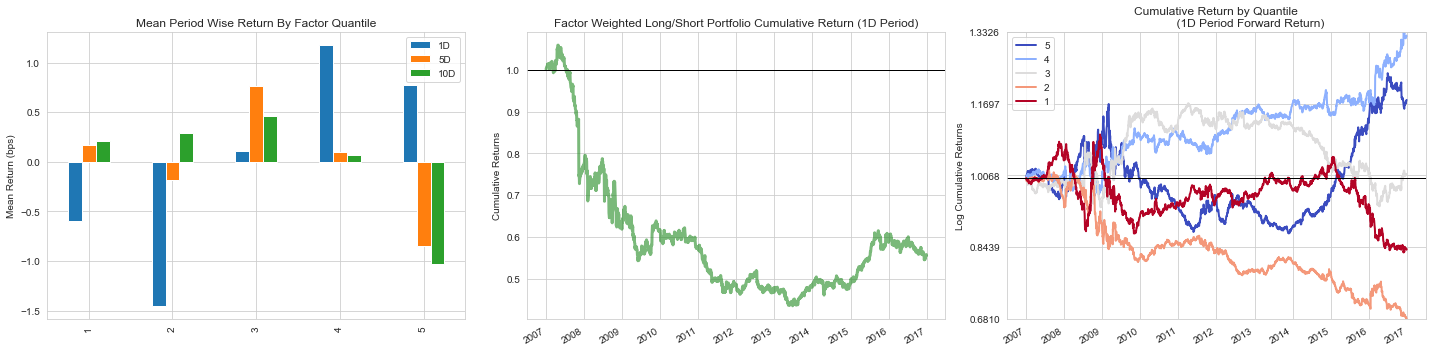

In [10]:
# Plot spread and cumulative returns
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))

mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data, by_group=False, demeaned=True)

mean_quant_rateret = mean_quant_ret.apply(utils.rate_of_return, axis=0, base_period=mean_quant_ret.columns[0])

plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])


factor_returns = perf.factor_returns(factor_data)

title = "Factor Weighted Long/Short Portfolio Cumulative Return (1D Period)"
plotting.plot_cumulative_returns(factor_returns['1D'], period='1D', freq=pd.tseries.offsets.BDay(),
                                 title=title, ax=axes[1])

plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate['1D'], freq=pd.tseries.offsets.BDay(),
                                             period='1D', ax=axes[2])
fig.tight_layout();

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-5.777115,2.424856e+18,1.149045e+15,2.391617e+16,250511,20.029808
2,-0.939835,5.904013e+19,1.436015e+17,1.346760e+18,250030,19.991349
3,-0.907624,9.944480e+20,3.561257e+18,2.418721e+19,249733,19.967602
4,-0.860158,2.018596e+22,7.354829e+19,4.143409e+20,250040,19.992148
5,-0.806923,1.335067e+30,5.882606e+25,5.127984e+27,250377,20.019093


Returns Analysis


,1D,5D,10D
Ann. alpha,-0.034,-0.004,-0.009
beta,-0.114,-0.136,-0.132
Mean Period Wise Return Top Quantile (bps),0.770,-0.848,-1.026
Mean Period Wise Return Bottom Quantile (bps),-0.593,0.170,0.205
Mean Period Wise Spread (bps),1.363,-1.039,-1.250


Information Analysis


,1D,5D,10D
IC Mean,0.006,0.000,-0.002
IC Std.,0.111,0.113,0.110
Risk-Adjusted IC,0.058,0.001,-0.021
t-stat(IC),2.918,0.072,-1.062
p-value(IC),0.004,0.942,0.288
IC Skew,-0.074,-0.212,-0.147
IC Kurtosis,0.756,0.998,1.252


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.785,0.786,0.785
Quantile 2 Mean Turnover,0.782,0.780,0.777
Quantile 3 Mean Turnover,0.765,0.761,0.761
Quantile 4 Mean Turnover,0.762,0.758,0.757
Quantile 5 Mean Turnover,0.669,0.662,0.662


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.059,0.07,0.073


<Figure size 432x288 with 0 Axes>

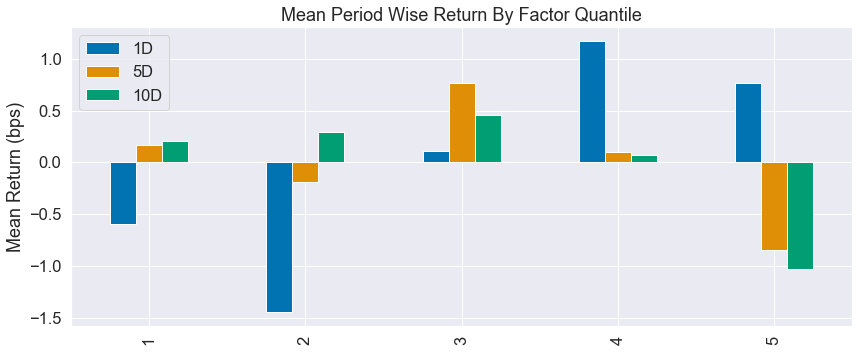

In [11]:
# Create Tearsheet
create_summary_tear_sheet(factor_data)